# NJ Transit + Amtrak (NEC) Rail Performance Analysis

The busiest passenger rail line in the United States, Amtrak also operates passenger rail service; together the NJ Transit and Amtrak operate nearly 750 trains across the NJ Transit rail network. Our data originates from here; https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance. This data is organized into a monthly performance report of nearly every train trip on the rail network with the features; date, train ID, stop sequence, station train is traveling from, station ID of train origin, station train is traveling to, train destination ID, scheduled time, actual time, and delay in minutes. We will clean and analyze these features for further machine learning.

In this analysis, we are going to find the answers for the below questions based on PCA/K-Means and Tsne/GMM approach through unsupervised models

1) Which cluster contains the most train delay on Friday?

2) Which cluster contains the most train delays for the rush hour in the weekday?


In [ ]:
# Importing the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

In [ ]:
# Importing rail data from May 2020.
df = pd.read_csv("C:/Users/Ram Subramanian/Desktop/Ram/Thinkful/2020_05.csv")

# Exploratory Data Analysis and Data Cleaning

In [1]:
# Examining the samples
df.head()

NameError: name 'df' is not defined

In [ ]:
# Examining DataFrame features data types.
df.info()

Data types seem to be correct for all features, we will further clean our data by dropping unneccesary columns.

In [ ]:
# Dropping to_id and from_id columns from our DataFrame.
df = df.drop(columns='to_id')
df = df.drop(columns='from_id')

Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables for easier interpretation. These will also not be useful for analysis.

In [ ]:
# Finding the percent of missing values by calling pandas .isna function which returns a mask of bool values for each element in
# DataFrame that indicates whether an element is not an NA value, and rounding the mean.
df.isna().mean().round(4) * 100

Checking the percentage of missing data in each feature. Stop_sequence, scheduled_time and delay_minutes need to have their missing values dropped for further machine learning.
These features are missing a significant amount of data, but for the most part our dataset is complete. We will drop the rows that are missing to save the intact information within them.

In [ ]:
# .dropna returns the DataFrame with missing values dropped.
df = df.dropna()

In [ ]:
# Confirming removal of missing values from DataFrame.
df.isna().mean().round(4) * 100

Now that we have cleaned our data we can go ahead and visualize some of the features of interest.

In [ ]:
# Creating distribution plot with 'delay_minutes' column.
sns.distplot(df['delay_minutes'])

This plot shows the distribution of our delay in minutes. Most delays were minor, with the highest density either having no delay or about a 5 minute delay. We will use this feature to create our target variable by creating a threshold that will alert to a delay greater than 15 minutes later.

In [ ]:
# Countplot for 'status'
sns.countplot(x ='status', data = df)

In [ ]:
# Countplot displaying train 'line' distribution
plt.figure(figsize=(20,6))
sns.countplot(x ='line', data = df)

The majority of train lines are coming from the North Jersey coast, the Morristown line, and the Northeastern Corridor train lines. We have the smallest amount of data for the Princeton Shuttle line. We will also one-hot encode these variables to feed into our machine model and determine any lines of interest.

In [ ]:
# Defining figure size with pyplot.
plt.figure(figsize=(12, 6))
# Applying correlation scoring to dataframe.
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
# Creating heatmap with seaborn.
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
                 linewidths=.2, cmap="YlGnBu")

The strongest correlation being displayed is the correlation between train line and delay in minutes, as well as the correlation between to and from destinations and delay in minutes.

# Unsupervised Learning

We will use KMeans and GMM clustering techniques on our data using PCA and t-SNE feature reduced data to see which combination of dimensionality reduction and clustering techniques works best for this dataset.

## PCA Feature Decomposition

In [ ]:
# Drop redundant columns once again from DataFrame.
df = df.drop(columns='scheduled_time')
df = df.drop(columns='actual_time')
df = df.drop(columns='date')


Dropping the scheduled time and actual time columns since we are only interested in the amount of delay which is measured and already extracted from these columns for us in the 'delay_minutes' feature. The date feature is also not important to our clustering model.

In [ ]:
# Dropping 'type' column, contains only one value.
df = df.drop(columns='type')

We can drop our type feature as after dropping missing values it only contains one unique value and won't contribute to our data.

In [ ]:
# Creating a new feature to indicate if a train is late or not, we will use a threshold of 10 minute delay time.
df['late'] = df['delay_minutes']>10

# We can now drop our delay column as we have extracted the necessary info from it.
df = df.drop(columns='delay_minutes')

# One-hot encoding statistical variables for machine learning.
df = pd.get_dummies(df, columns={'from','to','line','train_id','status','late'})

Before Principle Component Analysis, we must scale our features to bring the mean to zero and the standard deviation to 1.

In [ ]:
# Standardize features by removing the mean and scaling to unit variance with sklearns StandardScaler.
scaler = StandardScaler()

# Fit scaler to data by calling fit_transform on our data.
X_scale = scaler.fit_transform(df)

# Storing scaled data into new DataFrame.
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.head()

,stop_sequence,train_id_0069,train_id_0070,train_id_0071,train_id_0072,train_id_0073,train_id_0074,train_id_0075,train_id_0076,train_id_0077,...,line_Bergen Co. Line,line_Gladstone Branch,line_Main Line,line_Montclair-Boonton,line_Morristown Line,line_No Jersey Coast,line_Northeast Corrdr,line_Pascack Valley,line_Princeton Shuttle,line_Raritan Valley
0,-1.413841,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,...,-0.288942,-0.283713,-0.375015,-0.216326,-0.461205,-0.463982,-0.445778,-0.1861,-0.102824,3.228762
1,-1.213208,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,...,-0.288942,-0.283713,-0.375015,-0.216326,-0.461205,-0.463982,-0.445778,-0.1861,-0.102824,3.228762
2,-1.012575,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,...,-0.288942,-0.283713,-0.375015,-0.216326,-0.461205,-0.463982,-0.445778,-0.1861,-0.102824,3.228762
3,-0.811942,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,...,-0.288942,-0.283713,-0.375015,-0.216326,-0.461205,-0.463982,-0.445778,-0.1861,-0.102824,3.228762
4,-0.611309,-0.04984,-0.072035,-0.048432,-0.04984,-0.04984,-0.072035,-0.064126,-0.072035,-0.05188,...,-0.288942,-0.283713,-0.375015,-0.216326,-0.461205,-0.463982,-0.445778,-0.1861,-0.102824,3.228762


In [ ]:
# PCA with the number of components set to 2, this will reduce our data to two dimensions.
pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_scale)

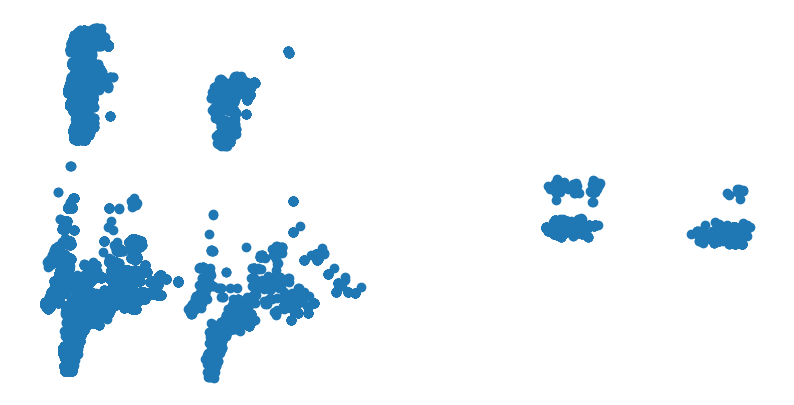

In [ ]:
# Defining pyplot figure size.
plt.figure(figsize=(10,5))

# Creating scatterplot of pca component dimensions with pyplot.
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

This scatterplot shows what our data looks like now reduced to two dimensions.

## Applying PCA to KMeans

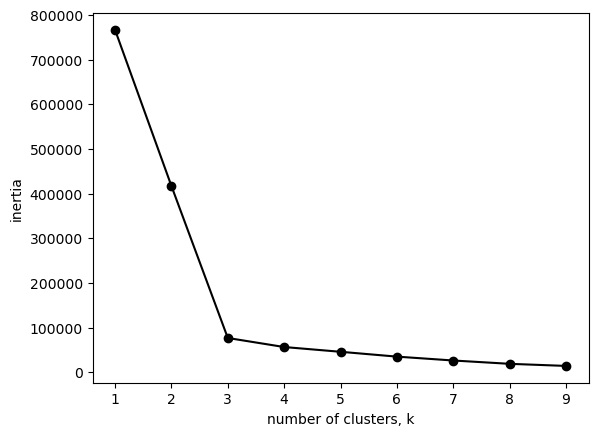

In [ ]:
# Components are now in Pandas DataFrame.
PCA_components = pd.DataFrame(pca_components)
# Create range of k values.
ks = range(1, 10)
inertias = []
for k in ks:
    # Create KMeans instance with k clusters: model.
    model = KMeans(n_clusters=k)

    # Fit model to samples.
    model.fit(PCA_components.iloc[:,:3])

    # Append the inertia to the list of inertias.
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

The elbow method here would give us a KMeans cluster value of 3.

Finding the best KMeans cluster value based on silhouette score

For Kmeans cluster number of 3
silhouette_score is 0.7753287599080637


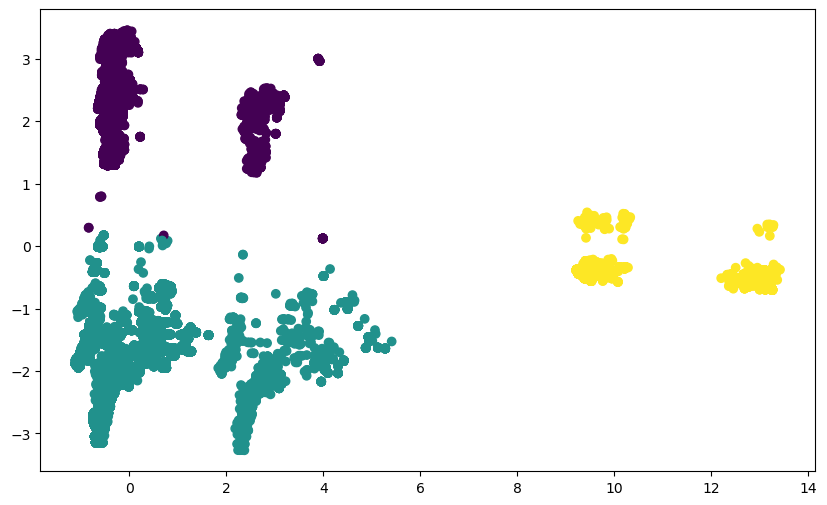

In [ ]:
#Finding the silhouette score based on KMeans cluster value '3'
kmeans  = KMeans(n_clusters=3, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)
# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 3')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

For Kmeans cluster number of 4
silhouette_score is 0.7837499834018796


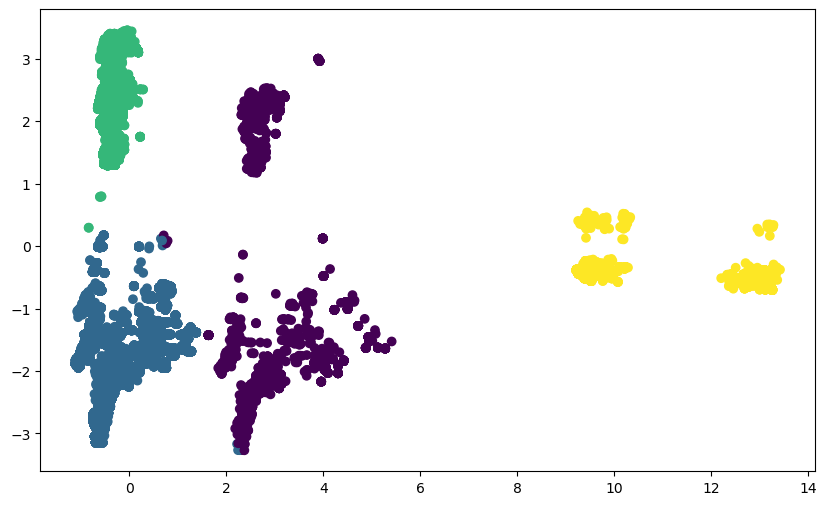

In [ ]:
#Finding the silhouette score based on KMeans cluster value '4'
kmeans  = KMeans(n_clusters=4, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)
# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 4')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

For Kmeans cluster number of 5
silhouette_score is 0.6179214613693473


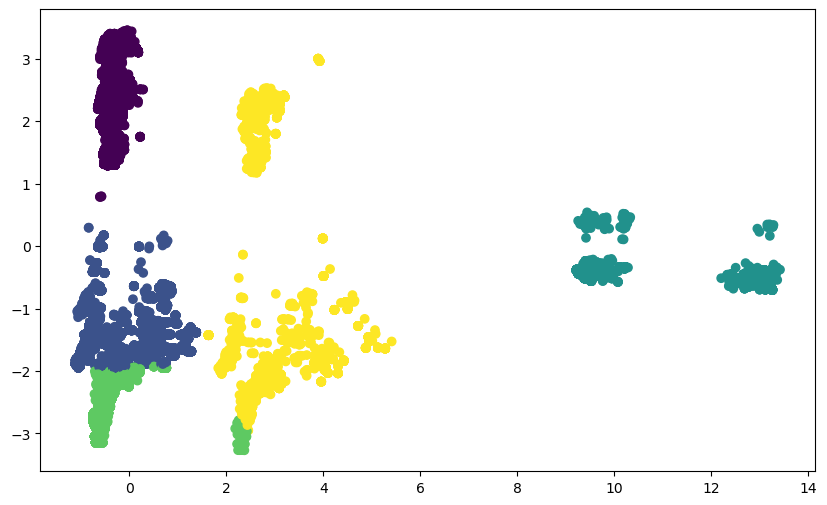

In [ ]:
#Finding the silhouette score based on KMeans cluster value '5'
kmeans  = KMeans(n_clusters=5, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)
# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 5')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

For Kmeans cluster number of 6
silhouette_score is 0.662626956251085


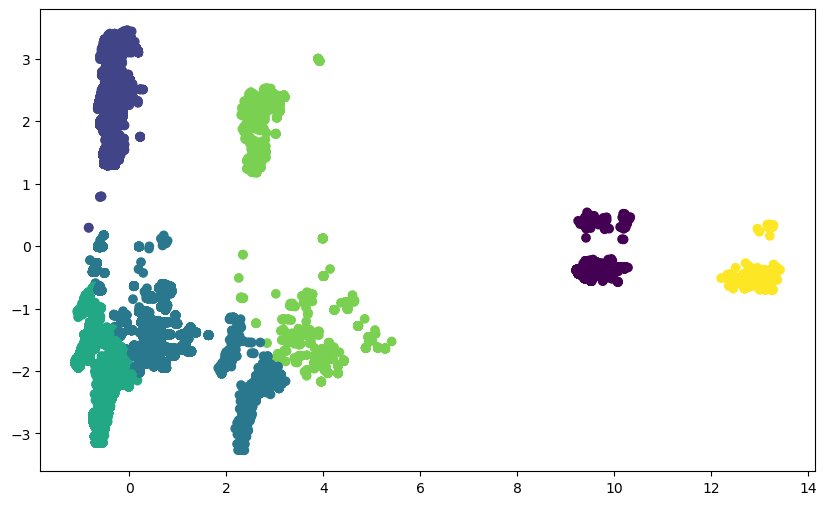

In [ ]:
#Finding the silhouette score based on KMeans cluster value '6'
kmeans  = KMeans(n_clusters=6, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)
# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 6')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

[During the time of execution] Based on silhouette score, K Means cluster '4' is best

In [ ]:
# Defining the k-means with the best silhouette value (4) and timing it.
kmeans_cluster = KMeans(n_clusters=4, random_state=123)
# Fitting and timing clustering.
%timeit kmeans_cluster.fit(PCA_components)
y_pred = kmeans_cluster.predict(PCA_components)

1.68 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing and building the best performing model with a KMeans value of 4 and a silhouette score of .78. A perfect silhouette score would be a value of 1.

## Cluster Analysis of KMeans Clusters using PCA

In [ ]:
# Creating a copy of our original dataframe before dummy variable creation and mapping our KMeans clusters onto it.
df2 = pd.read_csv("C:/Users/Ram Subramanian/Desktop/Ram/Thinkful/2020_05.csv")


df2.head()


,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2020-05-01,5543,1.0,Newark Penn Station,107,Newark Penn Station,107,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit
1,2020-05-01,5543,2.0,Newark Penn Station,107,Union,38105,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit
2,2020-05-01,5543,3.0,Union,38105,Roselle Park,31,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit
3,2020-05-01,5543,4.0,Roselle Park,31,Cranford,32,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit
4,2020-05-01,5543,5.0,Cranford,32,Westfield,155,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit


In [ ]:
# Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables.
df2 = df2.drop(columns='to_id')
df2 = df2.drop(columns='from_id')


In [ ]:
# Dropping missing values.
df2 = df2.dropna()


In [ ]:
#Defining the late records
df2['late'] = df2['delay_minutes']>10

Now that we have recreated our DataFrame before processing we can create a feature to label the data to its respective cluster.

In [ ]:
# Finally, attach the cluster labels from KMeans to the original DataFrame.
df2['cluster_label'] = kmeans_cluster.labels_

In [ ]:
# Examining DataFrame to confirm cluster labels have been attached.
df2.head()

,date,train_id,stop_sequence,from,to,scheduled_time,actual_time,delay_minutes,status,line,type,late,cluster_label
0,2020-05-01,5543,1.0,Newark Penn Station,Newark Penn Station,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit,False,2
1,2020-05-01,5543,2.0,Newark Penn Station,Union,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit,False,2
2,2020-05-01,5543,3.0,Union,Roselle Park,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit,False,2
3,2020-05-01,5543,4.0,Roselle Park,Cranford,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit,False,2
4,2020-05-01,5543,5.0,Cranford,Westfield,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit,False,2


In [ ]:
# Creating the dataframe which contains friday late records to answer the first question
df_friday = df2[pd.to_datetime(df2['date']).dt.dayofweek==4 ]
df_friday_late = df_friday[df_friday['delay_minutes']>10 ]


[Text(0, 0, '588'), Text(0, 0, '210'), Text(0, 0, '1')]

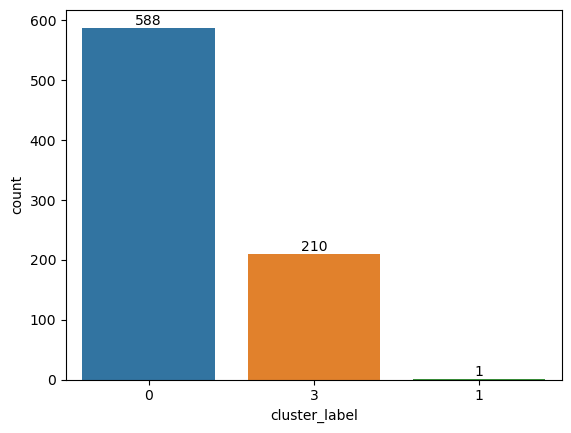

In [ ]:
#Finding the cluster which have more Friday late records
ax = sns.countplot(x=df_friday_late['cluster_label'],
                   order=df_friday_late['cluster_label'].value_counts(ascending=False).index);

abs_values = df_friday_late['cluster_label'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

During the time of execution, the Cluster 0 contains the most train delay on Friday

In [ ]:
# Creating the dataframe which contains most train delays for the rush hour in the weekday to answer the second question
df_weekday1 = df2[pd.to_datetime(df2['date']).dt.dayofweek!=5 ]
df_weekday2 = df_weekday1[pd.to_datetime(df_weekday1['date']).dt.dayofweek!=6 ]
df_weekday_late = df_weekday2[df_weekday2['delay_minutes']>10 ]
df_weekday_late['actual_time_hour'] = pd.to_datetime(df_weekday_late['actual_time']).dt.hour

<Axes: xlabel='actual_time_hour', ylabel='count'>

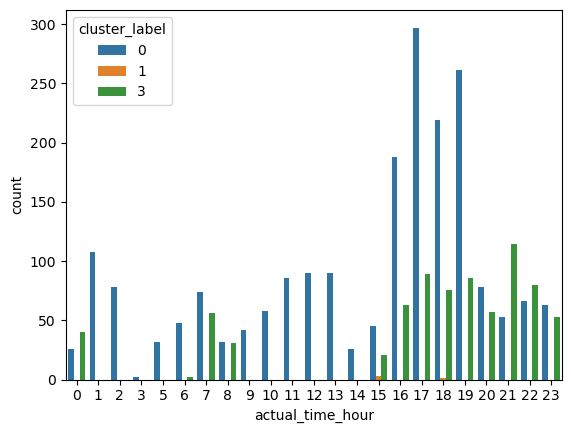

In [ ]:
#Finding the cluster which have most train delays for the rush hour in the weekday
sns.countplot(x ='actual_time_hour', data = df_weekday_late, hue= 'cluster_label')

During the time of execution, the Cluster 0 contains the most train delays for the rush hour in the weekday

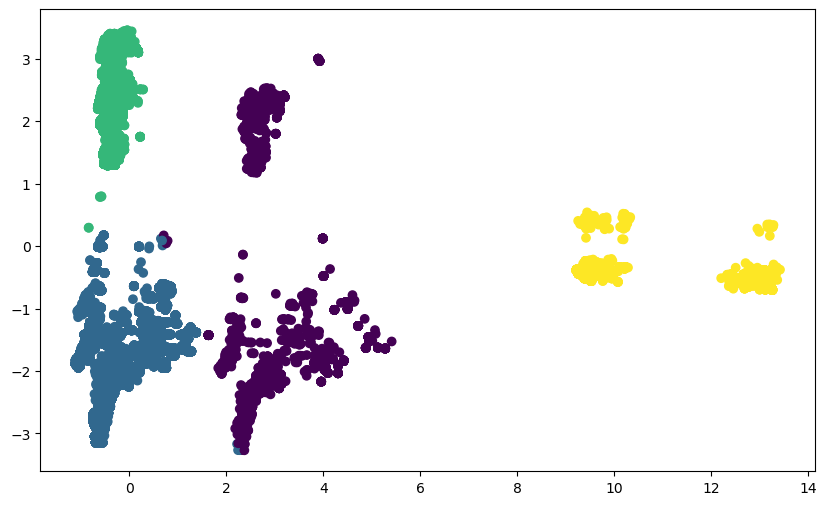

In [ ]:
#let's visualize the clusters formed by KMeans and PCA with a simple scatterplot.
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

[During the time of execution] Based on KMeans model through PCA, the Cluster 1 contains the most train delay on Friday and also the most train delays for the rush hour in the weekday

# t-SNE Dimensionality Reduction

Running and timing t-SNE. t-Distributed Stochastic Neighbor Embedding (t-SNE) is a newer method of dimensionality reduction like PCA. Unlike PCA it tries to minimize the Kullback–Leibler divergence (KL divergence) between the two dimensions which can allow for better visualization of high-dimensional data.

perplexity is  90
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 87172 samples in 0.369s...
[t-SNE] Computed neighbors for 87172 samples in 281.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional 

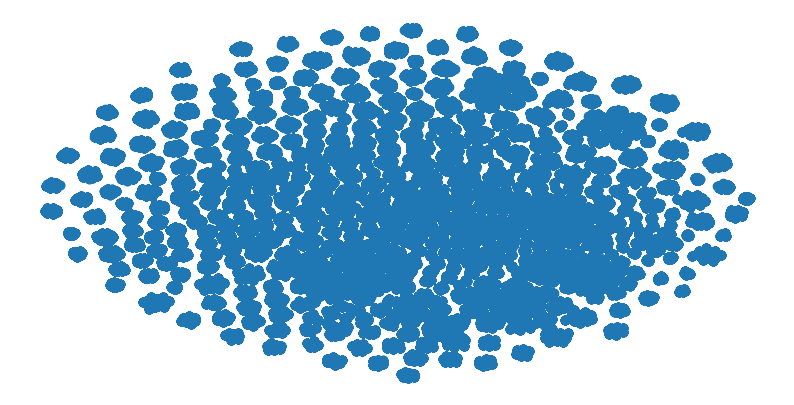

In [ ]:
import time
from sklearn.manifold import TSNE

perplexity = [90]

for i in perplexity:
    print ("perplexity is ",format(i))
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=1000)
    tsne_results = tsne.fit_transform(df_scale)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    plt.figure(figsize=(10,5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

In [ ]:
print(tsne_results)

[[-43.027935   22.70582  ]
 [-42.763924   22.95624  ]
 [-43.489582   20.632853 ]
 ...
 [-96.43391     1.3603866]
 [-96.46932     3.4219973]
 [-97.99298     5.5357885]]


Finding out the best cluster value for GMM

For GMM cluster number of 2
The silhouette score of the GMM solution: 0.004793960149756926


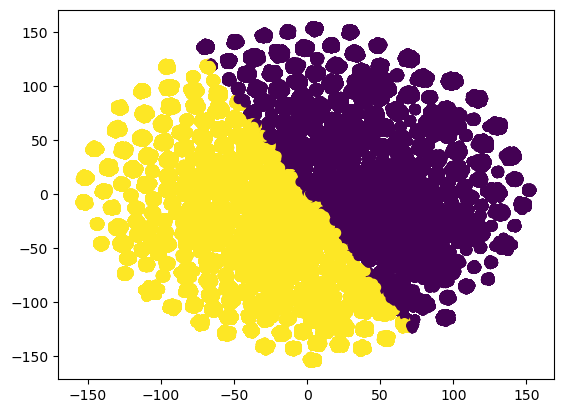

In [ ]:
# Finding the silhouette_score for GMM Cluster value 2
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 2')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

For GMM cluster number of 3
The silhouette score of the GMM solution: -0.02081008139140166


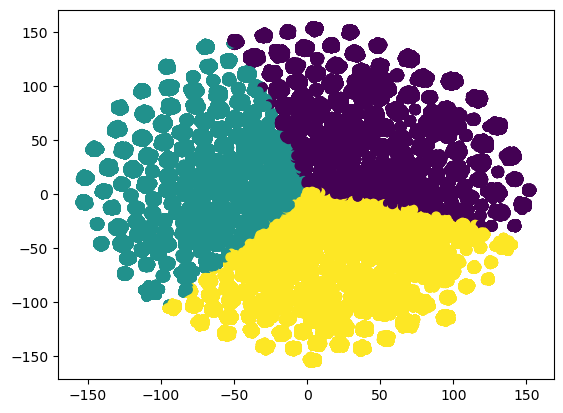

In [ ]:
# Finding the silhouette_score for GMM Cluster value 3
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 3')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

For GMM cluster number of 4
The silhouette score of the GMM solution: -0.03470794371517051


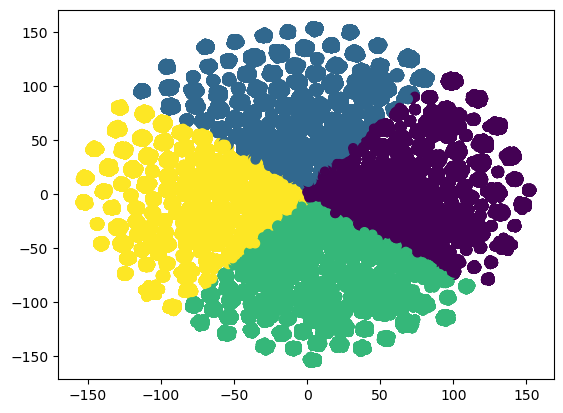

In [ ]:
# Finding the silhouette_score for GMM Cluster value 4
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=4, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 4')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

For GMM cluster number of 5
The silhouette score of the GMM solution: -0.03508623618042541


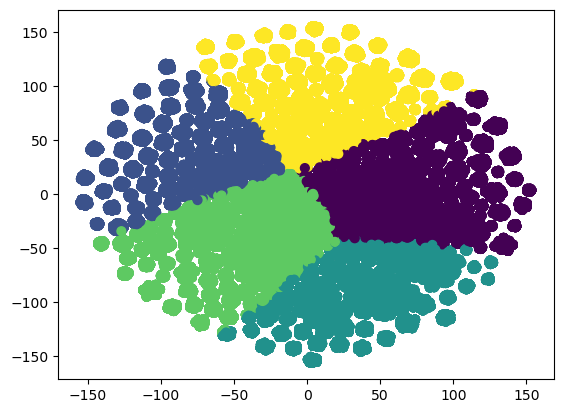

In [ ]:
# Finding the silhouette_score for GMM Cluster value 5
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 5')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

For GMM cluster number of 6
The silhouette score of the GMM solution: -0.03652366383559902


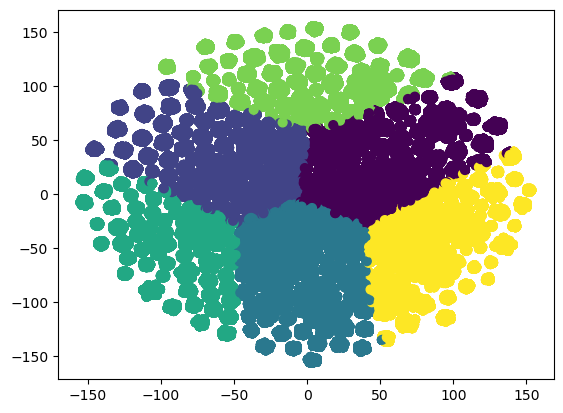

In [ ]:
# Finding the silhouette_score for GMM Cluster value 6
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=6, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 6')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

Based on the silhouette score, the GMM Cluster value 2 looks better but running with 4 clusters to see more grouping

For GMM cluster number of 4
The silhouette score of the GMM solution: -0.03470794371517051


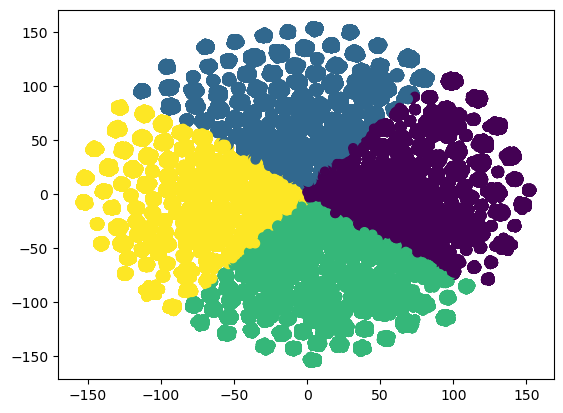

In [ ]:
# Defining the agglomerative clustering
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=4, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 4')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, s=40, cmap='viridis');

# Cluster Analysis of GMM Clusters using t-SNE

In [ ]:
# Creating a copy of our original dataframe before dummy variable creation and mapping our KMeans clusters onto it.
df3 = pd.read_csv("C:/Users/Ram Subramanian/Desktop/Ram/Thinkful/2020_05.csv")


df3.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2020-05-01,5543,1.0,Newark Penn Station,107,Newark Penn Station,107,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit
1,2020-05-01,5543,2.0,Newark Penn Station,107,Union,38105,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit
2,2020-05-01,5543,3.0,Union,38105,Roselle Park,31,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit
3,2020-05-01,5543,4.0,Roselle Park,31,Cranford,32,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit
4,2020-05-01,5543,5.0,Cranford,32,Westfield,155,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit


In [ ]:
# Dropping redundant features such as to_id and from_id since our actual locations are listed in features to and from and can be used as dummy variables.
df3 = df3.drop(columns='to_id')
df3 = df3.drop(columns='from_id')

In [ ]:
df3 = df3.dropna()

In [ ]:
#Defining the late records
df3['late'] = df3['delay_minutes']>10

In [ ]:
# Finally, attach the cluster labels from KMeans to the original DataFrame.
df3['cluster_label'] = clusters

In [ ]:
# Examining DataFrame to confirm cluster labels have been attached.
df3.head()

,date,train_id,stop_sequence,from,to,scheduled_time,actual_time,delay_minutes,status,line,type,late,cluster_label
0,2020-05-01,5543,1.0,Newark Penn Station,Newark Penn Station,2020-05-01 23:38:00,2020-05-01 23:40:09,2.150000,departed,Raritan Valley,NJ Transit,False,3
1,2020-05-01,5543,2.0,Newark Penn Station,Union,2020-05-01 23:47:00,2020-05-01 23:47:01,0.016667,departed,Raritan Valley,NJ Transit,False,3
2,2020-05-01,5543,3.0,Union,Roselle Park,2020-05-01 23:50:00,2020-05-01 23:51:04,1.066667,departed,Raritan Valley,NJ Transit,False,3
3,2020-05-01,5543,4.0,Roselle Park,Cranford,2020-05-01 23:55:00,2020-05-01 23:55:31,0.516667,departed,Raritan Valley,NJ Transit,False,3
4,2020-05-01,5543,5.0,Cranford,Westfield,2020-05-01 23:59:00,2020-05-01 23:59:01,0.016667,departed,Raritan Valley,NJ Transit,False,3


In [ ]:
# Creating the dataframe which contains friday late records to answer the first question
df_friday_GMM = df3[pd.to_datetime(df3['date']).dt.dayofweek==4 ]
df_friday_late_GMM = df_friday_GMM[df_friday_GMM['delay_minutes']>10 ]


[Text(0, 0, '4267'),
 Text(0, 0, '3832'),
 Text(0, 0, '3717'),
 Text(0, 0, '3695')]

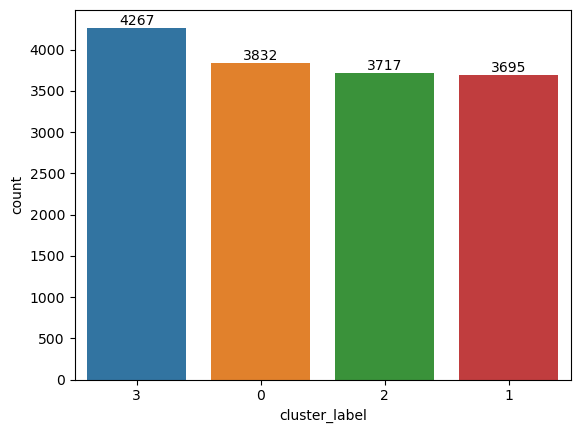

In [ ]:
#Finding the cluster which have more Friday late records
ax = sns.countplot(x=df_friday_GMM['cluster_label'],
                   order=df_friday_GMM['cluster_label'].value_counts(ascending=False).index);

abs_values = df_friday_GMM['cluster_label'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

During the time of execution, the Cluster 3 contains the most train delay on Friday

In [ ]:
# Creating the dataframe which contains most train delays for the rush hour in the weekday to answer the second question
df_weekday1_gmm = df3[pd.to_datetime(df3['date']).dt.dayofweek!=5 ]
df_weekday2_gmm = df_weekday1_gmm[pd.to_datetime(df_weekday1_gmm['date']).dt.dayofweek!=6 ]
df_weekday_late_gmm = df_weekday2_gmm[df_weekday2_gmm['delay_minutes']>10 ]
df_weekday_late_gmm['actual_time_hour'] = pd.to_datetime(df_weekday_late_gmm['actual_time']).dt.hour

<Axes: xlabel='actual_time_hour', ylabel='count'>

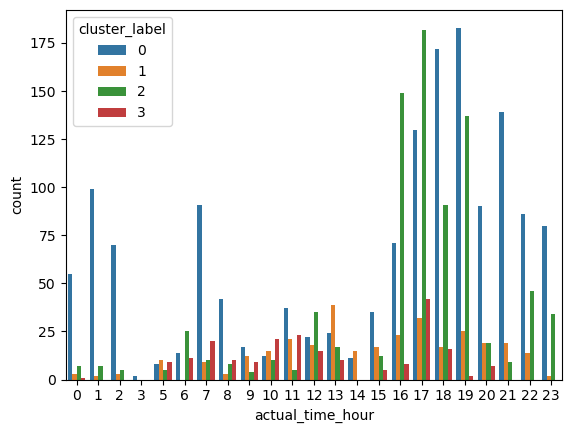

In [ ]:
#Finding the cluster which have most train delays for the rush hour in the weekday
sns.countplot(x ='actual_time_hour', data = df_weekday_late_gmm, hue= 'cluster_label')

During the time of execution, the Cluster 0 contains the most train delays for the rush hour in the weekday

# Conclusion

Based on the Analysis of KMeans Clusters using PCA and the GMM Clusters using t-SNE,

KMeans Clusters using PCA:
1) Performed model with a KMeans value of 4 and a silhouette score of .78
2) Cluster 0 contains the most train delay on Friday and also the most train delays for the rush hour in the weekday

GMM Clusters using t-SNE:
1) Performed model with a GMM value of 4 and a silhouette score of -0.025
2) Cluster 3 contains the most train delay on Friday
3) Cluster 0 contains the most train delays for the rush hour in the weekday